In [1]:
!pip install psycopg2-binary

import pandas as pd
import psycopg2
import pandas.io.sql as sqlio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import os 
from dotenv import load_dotenv

load_dotenv('mel.env')

user_ = os.getenv("DB_USER")
password_ = os.getenv("DB_PASSWORD")
host_ = os.getenv("DB_HOST")
port_ = os.getenv("DB_PORT")
database_ = os.getenv("DB_NAME")

try:    
    connection = psycopg2.connect(
        database=database_,
        host=host_,
        user=user_,
        password=password_,
        port=port_
    )


    print("Database connection successful!")
except Exception as e:
    print("Error connecting to the database:", e)

Database connection successful!


In [3]:
sf_df = sqlio.read_sql_query('SELECT * FROM sf_combined', connection)
sf_df.info()

/var/folders/9_/7hq_l8tj3zg43d4x7ptmxnlw0000gn/T/ipykernel_21354/2870464142.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sf_df = sqlio.read_sql_query('SELECT * FROM sf_combined', connection)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151729 entries, 0 to 1151728
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   ride_id             1151729 non-null  object        
 1   rideable_type       1151729 non-null  object        
 2   started_at          1151729 non-null  datetime64[ns]
 3   ended_at            1151729 non-null  datetime64[ns]
 4   start_station_name  1092079 non-null  object        
 5   start_station_id    1092079 non-null  object        
 6   end_station_name    1078533 non-null  object        
 7   end_station_id      1078161 non-null  object        
 8   start_lat           1151729 non-null  float64       
 9   start_lng           1151729 non-null  float64       
 10  end_lat             1151439 non-null  float64       
 11  end_lng             1151439 non-null  float64       
 12  member_casual       1151729 non-null  object        
 13  city        

# Dealing with Null values

Creating a Dictionary of lat and lng values - station name

In [4]:
decimal_places = 4

sf_df['start_lat_round'] = sf_df['start_lat'].round(decimal_places)
sf_df['start_lng_round'] = sf_df['start_lng'].round(decimal_places)
sf_df['end_lat_round'] = sf_df['end_lat'].round(decimal_places)
sf_df['end_lng_round'] = sf_df['end_lng'].round(decimal_places)

start_coords = sf_df.dropna(subset=['start_station_name'])[['start_station_name', 'start_lat_round', 'start_lng_round']].drop_duplicates()
end_coords = sf_df.dropna(subset=['end_station_name'])[['end_station_name', 'end_lat_round','end_lng_round']].drop_duplicates()

start_coords.rename(columns={'start_station_name': 'station_name',
                             'start_lat_round': 'lat',
                             'start_lng_round': 'lng'
                             }, inplace = True)
end_coords.rename(columns={'end_station_name': 'station_name',
                             'end_lat_round': 'lat',
                             'end_lng_round': 'lng'
                             }, inplace = True)

all_coords = pd.concat([start_coords, end_coords]).drop_duplicates(subset=['lat', 'lng'])

grouped_coords = all_coords.groupby('station_name').agg({
    'lat':np.mean,
    'lng':np.mean
}).reset_index()

station_coord_dict= {(row['lat'], row['lng']): row['station_name'] for _, row in grouped_coords.iterrows()}

/var/folders/9_/7hq_l8tj3zg43d4x7ptmxnlw0000gn/T/ipykernel_21354/3403250025.py:22: FutureWarning: The provided callable <function mean at 0x105fc8dc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_coords = all_coords.groupby('station_name').agg({
/var/folders/9_/7hq_l8tj3zg43d4x7ptmxnlw0000gn/T/ipykernel_21354/3403250025.py:22: FutureWarning: The provided callable <function mean at 0x105fc8dc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_coords = all_coords.groupby('station_name').agg({


Replacing Null values by finding closest station

In [5]:
from math import sqrt

end_station_nulls = sf_df[sf_df['end_station_name'].isnull()]

def eucladian_distance(lat1, lng1, lat2, lng2):
    return sqrt((lat1-lat2)**2 + (lng1-lng2)**2)

for idx, row in end_station_nulls.iterrows():
    lat, lng = row['end_lat'], row['end_lng']
    closest_station = None
    min_distance = float('inf')

    for (dict_lat, dict_lng), station_name in station_coord_dict.items():
        distance = eucladian_distance(lat, lng, dict_lat, dict_lng)
        if distance < min_distance:
            min_distance = distance
            closest_station = station_name 
    sf_df.at[idx, 'end_station_name'] = closest_station

sf_df.drop(columns=['start_lat_round','start_lng_round','end_lat_round','end_lng_round'], inplace=True)

In [6]:
sf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151729 entries, 0 to 1151728
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   ride_id             1151729 non-null  object        
 1   rideable_type       1151729 non-null  object        
 2   started_at          1151729 non-null  datetime64[ns]
 3   ended_at            1151729 non-null  datetime64[ns]
 4   start_station_name  1092079 non-null  object        
 5   start_station_id    1092079 non-null  object        
 6   end_station_name    1151439 non-null  object        
 7   end_station_id      1078161 non-null  object        
 8   start_lat           1151729 non-null  float64       
 9   start_lng           1151729 non-null  float64       
 10  end_lat             1151439 non-null  float64       
 11  end_lng             1151439 non-null  float64       
 12  member_casual       1151729 non-null  object        
 13  city        

In [8]:
start_station_nulls = sf_df[sf_df['start_station_name'].isnull()]

for idx, row in end_station_nulls.iterrows():
    lat, lng = row['end_lat'], row['end_lng']
    closest_station = None
    min_distance = float('inf')

    for (dict_lat, dict_lng), station_name in station_coord_dict.items():
        distance = eucladian_distance(lat, lng, dict_lat, dict_lng)
        if distance < min_distance:
            min_distance = distance
            closest_station = station_name 
    sf_df.at[idx, 'start_station_name'] = closest_station


In [11]:
new_nulls = sf_df[sf_df['start_station_name'].isnull()]

new_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39314 entries, 20477 to 1151010
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ride_id             39314 non-null  object        
 1   rideable_type       39314 non-null  object        
 2   started_at          39314 non-null  datetime64[ns]
 3   ended_at            39314 non-null  datetime64[ns]
 4   start_station_name  0 non-null      object        
 5   start_station_id    290 non-null    object        
 6   end_station_name    39024 non-null  object        
 7   end_station_id      39003 non-null  object        
 8   start_lat           39314 non-null  float64       
 9   start_lng           39314 non-null  float64       
 10  end_lat             39024 non-null  float64       
 11  end_lng             39024 non-null  float64       
 12  member_casual       39314 non-null  object        
 13  city                39314 non-null  object   

In [12]:
decimal_places = 4

sf_df['start_lat_round'] = sf_df['start_lat'].round(decimal_places)
sf_df['start_lng_round'] = sf_df['start_lng'].round(decimal_places)
sf_df['end_lat_round'] = sf_df['end_lat'].round(decimal_places)
sf_df['end_lng_round'] = sf_df['end_lng'].round(decimal_places)

start_coords2 = sf_df.dropna(subset=['start_station_name'])[['start_station_name', 'start_lat_round', 'start_lng_round']].drop_duplicates()
end_coords2 = sf_df.dropna(subset=['end_station_name'])[['end_station_name', 'end_lat_round','end_lng_round']].drop_duplicates()

start_coords2.rename(columns={'start_station_name': 'station_name',
                             'start_lat_round': 'lat',
                             'start_lng_round': 'lng'
                             }, inplace = True)
end_coords2.rename(columns={'end_station_name': 'station_name',
                             'end_lat_round': 'lat',
                             'end_lng_round': 'lng'
                             }, inplace = True)

all_coords2 = pd.concat([start_coords2, end_coords2]).drop_duplicates(subset=['lat', 'lng'])

grouped_coords2 = all_coords2.groupby('station_name').agg({
    'lat':np.mean,
    'lng':np.mean
}).reset_index()

station_coord_dict2= {(row['lat'], row['lng']): row['station_name'] for _, row in grouped_coords2.iterrows()}

/var/folders/9_/7hq_l8tj3zg43d4x7ptmxnlw0000gn/T/ipykernel_21354/3201171881.py:22: FutureWarning: The provided callable <function mean at 0x105fc8dc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_coords2 = all_coords2.groupby('station_name').agg({
/var/folders/9_/7hq_l8tj3zg43d4x7ptmxnlw0000gn/T/ipykernel_21354/3201171881.py:22: FutureWarning: The provided callable <function mean at 0x105fc8dc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_coords2 = all_coords2.groupby('station_name').agg({


In [13]:

for idx, row in new_nulls.iterrows():
    lat, lng = row['start_lat'], row['start_lng']
    closest_station2 = None
    min_distance2 = float('inf')

    for (dict_lat, dict_lng), station_name2 in station_coord_dict2.items():
        distance2 = eucladian_distance(lat, lng, dict_lat, dict_lng)
        if distance2 < min_distance2:
            min_distance2 = distance2
            closest_station2 = station_name2 
    sf_df.at[idx, 'start_station_name'] = closest_station2



In [15]:
sf_df.drop(columns=['start_lat_round', 'start_lng_round', 'end_lat_round','end_lng_round'], inplace=True)

Deleted rows where end station name, end lat and end lng were null (only 290) approx 0.025% of the total dataset.

In [18]:
sf_df = sf_df[~(
    sf_df['end_station_name'].isnull() & 
    sf_df['end_lat'].isnull() & 
    sf_df['end_lng'].isnull()
)]
print(f"Number of rows after deletion: {len(sf_df)}")

Number of rows after deletion: 1151439


### No null values (dropped id columns as we already have station info)

In [20]:
sf_df.drop(columns=['start_station_id', 'end_station_id'], inplace= True)

In [21]:
sf_df.reset_index(drop=True, inplace=True)
sf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151439 entries, 0 to 1151438
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   ride_id             1151439 non-null  object        
 1   rideable_type       1151439 non-null  object        
 2   started_at          1151439 non-null  datetime64[ns]
 3   ended_at            1151439 non-null  datetime64[ns]
 4   start_station_name  1151439 non-null  object        
 5   end_station_name    1151439 non-null  object        
 6   start_lat           1151439 non-null  float64       
 7   start_lng           1151439 non-null  float64       
 8   end_lat             1151439 non-null  float64       
 9   end_lng             1151439 non-null  float64       
 10  member_casual       1151439 non-null  object        
 11  city                1151439 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(6)
memory usage: 105.4+ MB


# Inspecting Datetime columns

In [22]:
print('Sample of started at and ended at columns:')
print(sf_df[['started_at', 'ended_at']].head())

Sample of started at and ended at columns:
           started_at            ended_at
0 2024-01-10 17:51:51 2024-01-10 17:57:03
1 2024-01-18 17:16:16 2024-01-18 17:25:23
2 2024-01-10 17:05:41 2024-01-10 17:20:03
3 2024-01-27 13:50:50 2024-01-27 14:00:26
4 2024-01-28 15:27:55 2024-01-28 15:48:06


In [23]:
sf_df['day_name'] = sf_df['started_at'].dt.day_name()
sf_df['month'] = sf_df['started_at'].dt.month_name()
sf_df['ride_date'] = sf_df['started_at'].dt.date

sf_df['ride_time_minutes'] = (sf_df['ended_at'] - sf_df['started_at']).dt.total_seconds()/60

In [25]:

sf_df['ride_time_minutes'] = sf_df['ride_time_minutes'].round(2)


print("Sample of rounded ride times:")
print(sf_df[['ride_time_minutes']].head())


Sample of rounded ride times:
   ride_time_minutes
0               5.20
1               9.12
2              14.37
3               9.60
4              20.18


# Testing for Outliers

In [26]:
sf_df['ride_time_minutes'].describe()

count    1.151439e+06
mean     1.265193e+01
std      2.076550e+01
min     -7.300000e-01
25%      5.420000e+00
50%      9.120000e+00
75%      1.474000e+01
max      1.499930e+03
Name: ride_time_minutes, dtype: float64

Max value is a lot higher than mean and median, so will look into outliers


Text(0.5, 0, 'ride time in minutes')

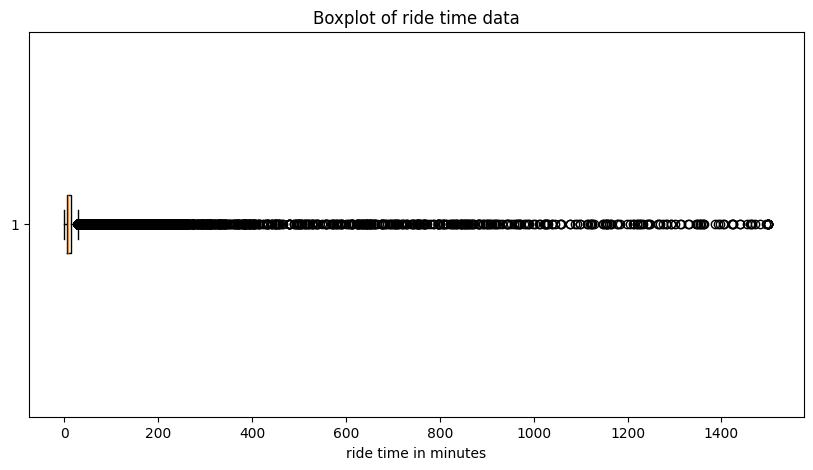

In [27]:
plt.figure(figsize=(10,5))
plt.boxplot(sf_df['ride_time_minutes'], vert=False)
plt.title('Boxplot of ride time data')
plt.xlabel('ride time in minutes')


In [28]:
#Percentiles and IQR
seventy_fifth = sf_df['ride_time_minutes'].quantile(0.75)
twenty_fifth = sf_df['ride_time_minutes'].quantile(0.25)
iqr_ridetime = seventy_fifth - twenty_fifth

#Upper and lower tresholds

upper_treshold = seventy_fifth + (1.5 * iqr_ridetime)
lower_treshold = twenty_fifth - (1.5 * iqr_ridetime)
print(upper_treshold, lower_treshold)

28.72 -8.56


Rides that are under a minute will be dropped.

In [29]:
sf_df[sf_df['ride_time_minutes'] < 0]
sf_df = sf_df[sf_df['ride_time_minutes'] >= 0]

In [30]:
outlier_data  = sf_df[(sf_df['ride_time_minutes'] > upper_treshold) | (sf_df['ride_time_minutes'] < lower_treshold)]
outlier_data.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,ride_time_minutes
count,73714,73714,73714.000000,73714.000000,73714.000000,73714.000000,73714.000000
mean,2024-06-25 23:57:26.867829760,2024-06-26 00:51:00.260452608,37.768322,-122.409810,37.768824,-122.413796,53.556546
min,2024-01-01 00:05:44,2024-01-01 00:42:12,37.280000,-122.511270,37.160000,-122.530000,28.730000
25%,2024-04-14 15:05:31.750000128,2024-04-14 15:53:57,37.768972,-122.458282,37.768907,-122.465931,32.820000
50%,2024-07-12 07:09:05.442000128,2024-07-12 08:09:16.686000128,37.777899,-122.426203,37.778557,-122.431802,39.770000
75%,2024-10-06 12:52:28.052499968,2024-10-06 13:46:09.938499840,37.796593,-122.400808,37.799175,-122.404689,55.120000
max,2024-10-31 23:16:04.286000,2024-10-31 23:53:08.201000,37.880262,-121.810000,37.950000,-121.660000,1499.930000
std,NaN,NaN,0.082062,0.108383,0.082656,0.109819,66.399152


In [31]:
outlier_data.sort_values(by='ride_time_minutes', ascending=False)

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,city,day_name,month,ride_date,ride_time_minutes
57516,B4951B2EBE38009C,electric_bike,2024-01-02 16:57:59.000,2024-01-03 17:57:55.000,10th St at Empire St,10th St at Empire St,37.331995,-121.881617,37.350000,-121.890000,casual,San Francisco,Tuesday,January,2024-01-02,1499.93
812523,D426AB0C06FA4B7E,classic_bike,2024-10-21 14:56:31.819,2024-10-22 15:56:26.629,San Carlos St at Market St,San Carlos St at Market St,37.339146,-121.884105,37.330000,-121.890000,casual,San Francisco,Monday,October,2024-10-21,1499.91
212512,4B5DD51F3DDB08B7,classic_bike,2024-04-02 18:54:56.000,2024-04-03 19:54:50.000,Julian St at The Alameda,Julian St at The Alameda,37.332233,-121.912516,37.330000,-121.910000,casual,San Francisco,Tuesday,April,2024-04-02,1499.90
64416,ADDF10A80DF41840,classic_bike,2024-01-06 23:18:51.000,2024-01-08 00:18:41.000,San Carlos St at Market St,San Carlos St at Market St,37.323345,-121.913497,37.330000,-121.890000,casual,San Francisco,Saturday,January,2024-01-06,1499.83
71855,BE55AC5DE970A84A,classic_bike,2024-01-09 13:08:12.000,2024-01-10 14:07:58.000,23rd St at Taylor St,23rd St at Taylor St,37.360001,-121.878778,37.360000,-121.880000,member,San Francisco,Tuesday,January,2024-01-09,1499.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213513,AD107776154329E5,classic_bike,2024-04-24 14:58:34.000,2024-04-24 15:27:18.000,Frank H Ogawa Plaza,62nd St at Claremont Ave,37.804562,-122.271738,37.849435,-122.252541,member,San Francisco,Wednesday,April,2024-04-24,28.73
110712,F773C89232280465,electric_bike,2024-01-27 17:38:49.000,2024-01-27 18:07:33.000,Lincoln Blvd at Graham St,Fillmore St at Jefferson St,37.801763,-122.456265,37.805376,-122.437261,casual,San Francisco,Saturday,January,2024-01-27,28.73
297823,4E34904A2ADBE3C7,classic_bike,2024-04-18 20:03:09.000,2024-04-18 20:31:53.000,Carroll Ave at 3rd St,Valencia St at 16th St,37.725372,-122.393954,37.765429,-122.421890,casual,San Francisco,Thursday,April,2024-04-18,28.73
667422,F0956C0CAA87C060,classic_bike,2024-07-24 14:19:56.014,2024-07-24 14:48:39.731,Funston Ave at Fulton St,JFK Dr at Great Hwy,37.773587,-122.471357,37.770479,-122.510594,casual,San Francisco,Wednesday,July,2024-07-24,28.73


We have 15 values with ride times over 24hrs those will be considered outliers and will be dropped

In [32]:
(outlier_data['ride_time_minutes'] > 1440).value_counts()

ride_time_minutes
False    73699
True        15
Name: count, dtype: int64

In [33]:
sf_df = sf_df[sf_df['ride_time_minutes'] < 1440].reset_index(drop=True)

In [34]:
sf_df.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,ride_time_minutes
count,1151414,1151414,1.151414e+06,1.151414e+06,1.151414e+06,1.151414e+06,1.151414e+06
mean,2024-06-25 08:50:15.584241152,2024-06-25 09:02:53.558249984,3.777192e+01,-1.223985e+02,3.777208e+01,-1.223981e+02,1.263290e+01
min,2024-01-01 00:00:37,2024-01-01 00:10:12,3.728000e+01,-1.225113e+02,3.716000e+01,-1.225300e+02,0.000000e+00
25%,2024-04-12 07:23:36.249999872,2024-04-12 07:31:39.249999872,3.776823e+01,-1.224307e+02,3.776823e+01,-1.224296e+02,5.420000e+00
50%,2024-07-12 19:26:26.329499904,2024-07-12 19:38:56.876000,3.777713e+01,-1.224125e+02,3.777755e+01,-1.224117e+02,9.120000e+00
75%,2024-10-07 21:10:04.975499776,2024-10-07 21:19:46.043500032,3.779024e+01,-1.223953e+02,3.779030e+01,-1.223953e+02,1.474000e+01
max,2024-10-31 23:56:36.320000,2024-10-31 23:59:44.805000,3.788060e+01,-1.218100e+02,4.075418e+01,-7.399647e+01,1.439870e+03
std,NaN,NaN,6.788533e-02,8.742322e-02,6.802562e-02,1.082189e-01,2.007683e+01


In [35]:
sf_df.sort_values(by='ride_time_minutes', ascending=False)

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,city,day_name,month,ride_date,ride_time_minutes
1099029,F697F581EF1ECC28,classic_bike,2024-10-25 10:54:53.323,2024-10-26 10:54:45.662,San Carlos St at Meridian Ave,San Carlos St at Meridian Ave,37.323345,-121.913497,37.323345,-121.913497,casual,San Francisco,Friday,October,2024-10-25,1439.87
62458,2B926A1F488DF9B8,classic_bike,2024-01-15 12:05:15.000,2024-01-16 11:50:36.000,Arguello Blvd at Edward St,Great Hwy at Balboa St,37.778487,-122.458645,37.775211,-122.511208,member,San Francisco,Monday,January,2024-01-15,1425.35
62421,C176A9C8B23062D5,classic_bike,2024-01-15 12:06:07.000,2024-01-16 11:50:36.000,Arguello Blvd at Edward St,Great Hwy at Balboa St,37.778487,-122.458645,37.775211,-122.511208,member,San Francisco,Monday,January,2024-01-15,1424.48
1125607,9ABD5D8FDAFC8933,classic_bike,2024-10-21 09:18:07.518,2024-10-22 09:01:20.571,North Point St at Powell St,The Embarcadero at Sansome St,37.806929,-122.411536,37.804770,-122.403234,casual,San Francisco,Monday,October,2024-10-21,1423.22
4570,E7770C4DB70A136A,classic_bike,2024-01-29 07:47:22.000,2024-01-30 07:29:43.000,Brannan St at 7th St,Mississippi St at 17th St,37.772438,-122.403924,37.764794,-122.394760,member,San Francisco,Monday,January,2024-01-29,1422.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180312,2A12D07479003A06,classic_bike,2024-01-22 17:28:43.000,2024-01-22 17:28:43.000,Grove St at Gough St,Grove St at Gough St,37.777870,-122.422953,37.777870,-122.422953,member,San Francisco,Monday,January,2024-01-22,0.00
70145,536B5D4FBB1C0EE3,electric_bike,2024-01-23 17:40:05.000,2024-01-23 17:40:05.000,Lyon St at Lombard St,Lyon St at Lombard St,37.798231,-122.447395,37.798198,-122.447414,member,San Francisco,Tuesday,January,2024-01-23,0.00
44802,4E286E8A55788EF8,classic_bike,2024-01-27 17:36:10.000,2024-01-27 17:36:10.000,40th St at Piedmont Ave,40th St at Piedmont Ave,37.825785,-122.253470,37.825785,-122.253470,member,San Francisco,Saturday,January,2024-01-27,0.00
327209,CA277920EF8AC879,electric_bike,2024-04-30 17:56:16.000,2024-04-30 17:56:16.000,Folsom St at 9th St,Folsom St at 9th St,37.773491,-122.411738,37.773717,-122.411647,member,San Francisco,Tuesday,April,2024-04-30,0.00


In [36]:
sf_df['ride_time_hrs'] = sf_df['ride_time_minutes'] / 60

In [37]:
sf_df['ride_time_hours'] = sf_df['ride_time_hrs'].round(1)


In [38]:
sf_df = sf_df.drop(columns='ride_time_hrs')

In [41]:
hourly_third_percentile = sf_df['ride_time_hours'].quantile(0.75)
hourly_first_percentile = sf_df['ride_time_hours'].quantile(0.25)
hourly_iqr = hourly_third_percentile - hourly_first_percentile

hourly_upper_limit = hourly_third_percentile + (1.5 * hourly_iqr)
print(hourly_upper_limit)

0.35000000000000003


Since total rides over 5+ hours account for 0.043% of the data, will consider them anomalies and drop.

In [42]:
# Round ride_time_hours to the nearest whole number
sf_df['ride_time_hours_rounded'] = sf_df['ride_time_hours'].round()

# Get the count of each hour
hour_counts = sf_df['ride_time_hours_rounded'].value_counts().sort_index()

# Display the counts
print(hour_counts)


ride_time_hours_rounded
0.0     1096818
1.0       48311
2.0        4946
3.0         633
4.0         206
5.0          68
6.0          60
7.0          36
8.0          38
9.0          21
10.0         32
11.0         34
12.0         28
13.0         26
14.0         31
15.0         20
16.0         17
17.0         14
18.0          9
19.0         17
20.0         13
21.0         10
22.0         10
23.0         11
24.0          5
Name: count, dtype: int64


In [43]:

sf_df = sf_df[(sf_df['ride_time_hours_rounded'] <= 3) & (sf_df['ride_time_minutes'] >= 1)]

# Verify the result
print(f"Rows remaining after filtering: {sf_df.shape[0]}")



Rows remaining after filtering: 1134286


In [45]:
##Minutes!!

new_iqr_mins = 1.484000e+01 - 5.570000e+00
new_upper_limit_mins = 1.484000e+01 + (1.5 * new_iqr_mins)
new_lower_limit_mins = 5.570000e+00 - (1.5 * new_iqr_mins)

print(new_lower_limit_mins, new_upper_limit_mins)

-8.334999999999999 28.744999999999997


In [47]:
sf_df = sf_df.reset_index(drop=True)

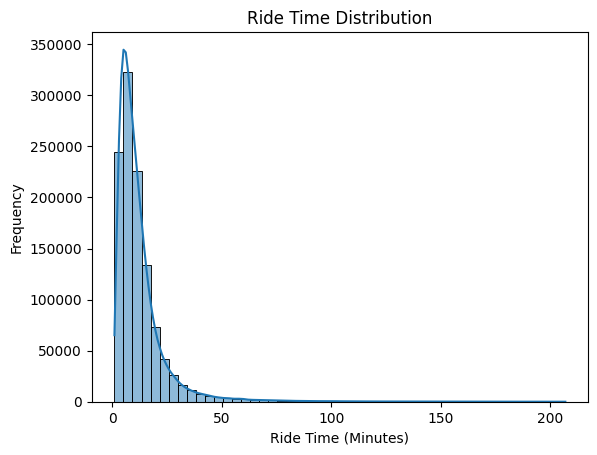

In [49]:

sns.histplot(sf_df['ride_time_minutes'], bins=50, kde=True)
plt.title('Ride Time Distribution')
plt.xlabel('Ride Time (Minutes)')
plt.ylabel('Frequency')
plt.show()



In [51]:
sf_df['member_casual'].value_counts()

member_casual
member    847377
casual    286909
Name: count, dtype: int64

Adding derived columns for later

In [52]:
sf_df['duration_category'] = pd.cut(
    sf_df['ride_time_minutes'],
    bins = [0, 15, 60, float('inf')],
    labels= ['Short', 'Medium', 'Long'],
    include_lowest=True
)

# example: 
# 0	Short
# 15	Short
# 30	Medium
# 61	Long

In [53]:
#Purpose:
# Categorize the starting times of rides into periods of the day:

# Morning: 6:00 AM – 12:00 PM
# Afternoon: 12:00 PM – 6:00 PM
# Evening: 6:00 PM – 12:00 AM
# Night: 12:00 AM – 6:00 AM

sf_df['start_hour'] = sf_df['started_at'].dt.hour

sf_df['time_of_day'] = pd.cut(
    sf_df['start_hour'],
    bins=[0, 6, 12, 18, 24],  # Define the time ranges
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],  # Assign labels
    right=False  # Make bins left-inclusive and right-exclusive
)

In [54]:
#Purpose:
# Classify each ride as occurring on a weekday or weekend.

sf_df['day_type'] = np.where(sf_df['day_name'].isin(['Saturday', 'Sunday']), 'Weekend', 'Weekday')


In [56]:
# Drop redundant columns
columns_to_drop = ['ride_date', 'ride_time_hours', 'ride_time_hours_rounded']
sf_df = sf_df.drop(columns=columns_to_drop)


In [59]:
def calculate_sf_ride_cost(row):
    # Extract relevant data
    bike_type = row['rideable_type']
    rider_type = row['member_casual']
    ride_time = row['ride_time_minutes']

    # Casual riders
    if rider_type == 'casual':
        if bike_type == 'classic_bike':
            # $3.99 for 30 min + $0.30/min for anything over 30 mins
            if ride_time <= 30:
                return 3.99
            else:
                return 3.99 + (ride_time - 30) * 0.30
        elif bike_type == 'electric_bike':
            # $3.99 to unlock + $0.30/min for the entire ride
            return 3.99 + ride_time * 0.30

    # Members
    elif rider_type == 'member':
        if bike_type == 'classic_bike':
            # Free for 45 minutes, then $0.20/min for anything over 45 mins
            if ride_time <= 45:
                return 0  # Free for rides within 45 minutes
            else:
                return (ride_time - 45) * 0.20
        elif bike_type == 'electric_bike':
            # $0.15/min for the entire ride
            return ride_time * 0.15

    # Default case
    return 0

# Apply the corrected function to calculate the ride cost for SF dataset
sf_df['ride_cost'] = sf_df.apply(calculate_sf_ride_cost, axis=1)

# Preview the updated SF DataFrame
sf_df[['rideable_type', 'member_casual', 'ride_time_minutes', 'ride_cost']].head()



,rideable_type,member_casual,ride_time_minutes,ride_cost
0,classic_bike,member,5.20,0.0000
1,electric_bike,member,9.12,1.3680
2,electric_bike,member,14.37,2.1555
3,classic_bike,casual,9.60,3.9900
4,electric_bike,casual,20.18,10.0440


In [60]:
# Subset for classic_bike and check cost calculations
classic_bike = sf_df[sf_df['rideable_type'] == 'classic_bike']

# Preview for both members and casual riders
print("Classic Bike - Members")
print(classic_bike[classic_bike['member_casual'] == 'member'][['ride_time_minutes', 'ride_cost']].head())

print("\nClassic Bike - Casual Riders")
print(classic_bike[classic_bike['member_casual'] == 'casual'][['ride_time_minutes', 'ride_cost']].head())



Classic Bike - Members
    ride_time_minutes  ride_cost
0                5.20        0.0
9                5.00        0.0
17               4.00        0.0
23              12.27        0.0
24               1.95        0.0

Classic Bike - Casual Riders
    ride_time_minutes  ride_cost
3                9.60       3.99
18              15.80       3.99
19               1.13       3.99
38              10.50       3.99
45               9.23       3.99


In [61]:
sf_df['ride_cost'] = sf_df['ride_cost'].round(2)

In [62]:
# Random sample of 50 rows
random_sample = sf_df.sample(n=50, random_state=42)  # Set random_state for reproducibility

# Display the required columns
print(random_sample[['rideable_type', 'member_casual', 'ride_time_minutes', 'ride_cost']])


         rideable_type member_casual  ride_time_minutes  ride_cost
843158    classic_bike        member               7.34       0.00
84353    electric_bike        member               6.02       0.90
781945   electric_bike        member               8.70       1.30
680496    classic_bike        member               8.53       0.00
819435   electric_bike        member               5.30       0.80
729042   electric_bike        casual              49.99      18.99
340501   electric_bike        member               3.57       0.54
700444   electric_bike        casual              50.46      19.13
1029230  electric_bike        casual              18.67       9.59
107260    classic_bike        member              18.00       0.00
1050718  electric_bike        member               7.65       1.15
663973   electric_bike        member              16.68       2.50
888701   electric_bike        member               2.74       0.41
615103   electric_bike        casual               6.33       

In [64]:
all_stations = pd.concat([sf_df['start_station_name'], sf_df['end_station_name']])

print(len(all_stations.unique()))

652


5. Getting most used station data

In [65]:
sf_start_usage = sf_df['start_station_name'].value_counts().reset_index() 
sf_start_usage.columns = ['station_name', 'start_count']

sf_end_usage = sf_df['end_station_name'].value_counts().reset_index()
sf_end_usage.columns = ['station_name', 'end_count']

sf_station_data = pd.merge(sf_start_usage, sf_end_usage, on='station_name', how='outer')
sf_station_data.fillna(0, inplace=True)

sf_station_data['total_visits'] = sf_station_data['start_count'] + sf_station_data['end_count']
sf_station_data = sf_station_data.sort_values(by='total_visits', ascending=False)

sf_station_data[['start_count', 'end_count', 'total_visits']] = sf_station_data[['start_count', 'end_count', 'total_visits']].astype(int)

sf_station_data = sf_station_data.reset_index(drop=True)
sf_station_data.head(10)

,station_name,start_count,end_count,total_visits
0,Market St at Steuart St,13284,14371,27655
1,Market St at 10th St,9098,9394,18492
2,Mechanics Monument Plaza,8955,9374,18329
3,Mission Playground,8831,9234,18065
4,North Point St at Polk St,8880,8984,17864
5,Waller St at Shrader St,8082,7391,15473
6,2nd St at Townsend St,7150,7499,14649
7,Grove St at Divisadero,7270,7298,14568
8,22nd St Caltrain Station,7148,7286,14434
9,Market St at Dolores St,7758,6666,14424
